# Optimum Filter Demo: NxMx1 Covariance Matrix

Author: Maggie Reed, maggie_reed@berkeley.edu

Last updated: 06/24/2024

-----



# Overview and Purpose

This demo notebook is for Spice/Herald members who wish to utilize the NxMx1 covariance matrix for optimum filter formalism.

The NxM refers to the number of channels (N) and templates (M) in a signal analysis. The most simple version of this is the OF1x1, which we most generally use. The last number in the case of the NxMx1, is the number of time degrees of freedom allowed. We will elaborate on this further in the Time DOF section. 

There are certain physical cases in which a multi channel multi template signal analysis is needed. For beginner users, it is helpful to first read about single channel single template OF's, then refer to this in depth dive in the OFnxm: https://docs.google.com/presentation/d/12yg3HD5RzjTVMer2BugB8U7X3dbev-lDzYIQkY4OczY/edit#slide=id.p in which several example cases are discussed. 

# Theory
-------

Optimal filters are our way to reconstruct the energies of events that occur within our detectors. Loosely speaking, we extract the best estimate of some pulse amplitude from data which has some known noise. 

A single actual event $Y(t)$ is constructed as the following: 

$$
Y(t) = A*T(t) + n(t)
$$

Where $A$ is the amplitude of the signa that we wish to extract, $T(t)$ is the time dependent template that we input, which describes our best guess to how the signal will be shaped, and $n(t)$ is the known noise. Simply moving things around we can get to an equation for the residual:
$$
Y(t)-A*T(t) = n(t)
$$
We want the best $A$ that minimizes the "residual" (the noise) $n(t)$. It is standard to square everything to make the solving/minimizing easier:
$$
|(n(t)|^2 = n^Tn = (Y-AT)^TC^{-1}(Y-AT)
$$
Where $C$ is a matrix which represents the squares of the uncertainties (the variance) along the diagonal. This is needed since our values (our signal) in $Y$ will have some uncertainties. From here, we can define the $\chi{^2}$:
$$
\chi^2 = \int df\frac{|Y(f)-AT(f)|^2}{C}
$$
All of the above is standard for a single channel, single template case. Now lets repeat the above for the case of multiple channels, with each channel having multiple templates. In this case, the noise term will become a cross correlated noise matrix (CSD) or a covariance matrix, since we must account for any noise that is shared between channels when we weight by the noise in the $\chi^2$. 

The frequency is $f$, the channels are $N$, and the templates are $M$. Our signal is:
$$
Y_{fi}=\sum_{i=1}^{N}\sum_{\alpha=1}^{M}A_{\alpha}*T_{fi\alpha}+n
$$
Explicitly, $C$ must be defined *across* channels, and so will have the following form:
$$
\sum_{i}^{N}\sum_{j}^{N}C_{fij}
$$
Finally, before we define the unsimplified version of our $\chi^2$, we must move forward under the following assumption: for a given channel, we multiply across all possible combinations of templates and amplitudes. i.e.:
$$
\sum_{i}^{N}\sum_{j}^{N}\sum_{\alpha}^{M} => \sum_{i}^{N}\sum_{j}^{N}\sum_{\alpha}^{M}\sum_{\beta}^{M}
$$
If you have difficulty understanding or visualizing the above, it will help you to write out a few of the matrix terms explicitly.

Now we may write out our $\chi^2$ as:
$$
\chi^2 = \sum_{i}^{N}\sum_{j}^{N}\sum_{\alpha}^{M}\sum_{\beta}^{M} (Y_{fi}-A_{\alpha}*T_{fi\alpha})^T C^{-1}(Y_{fj}-A_{\beta}*T_{fj\beta})
$$

Skipping all of the solving and rearranging, we end up with a few important terms we will use to define the simplified $\chi^2$, and the amplitude. One thing to keep in mind is that for a many event analysis anything that can be precomputed **should be**, since everything above is done in frequency domain. 

The optimal filter: 

The weighting matrix:

The filtered, rotated signal: 

The amplitude(s): 

The simplified $\chi^2$: 

# Algorithm Structure
--------

You may skip this section if you are already familiar with the structure of QETpy core functions. 

The QETpy repository houses the core functions needed to construct optimal filters for multi signal analysis. The detprocess repository houses the multievent filtering algorithm based on user input. For a single event, the order of operations is as follows:



# Setup

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import qetpy as qp
import pytesdaq
import numpy as np
from qetpy.core import OFnxm
from qetpy.core import OFBase

### First lets simulate some signals. We do this from noise generated from a real detector. 

In [2]:
save_dict_name = 'of_nxm_demo_files/didvresult_muon_example'
with open(save_dict_name, 'rb') as handle:
    offsets_dict = pickle.load(handle)

#### Create noise

In [3]:
# Generate noise
fs=1.25e6
f = np.fft.fftfreq(32768, d=1/fs)
noise_inst = qp.sim.TESnoise(freqs=f, didv_result=offsets_dict)
noise_sim = noise_inst.s_iload(freqs=f) + noise_inst.s_ites(freqs=f) + noise_inst.s_itfn(freqs=f)

# create 100 noise traces for 2 channels
noise_1 = qp.gen_noise_from_psd(noise_sim, fs=fs, ntraces=100)
noise_2 = qp.gen_noise_from_psd(noise_sim, fs=fs, ntraces=100)

# let calcualte 2 channels CSD and psd
nchans = 2
nbins = noise_1.shape[-1]
# noise matrix
print('Calculating CSD and PSD')
noise_matrix = np.zeros((100,nchans,nbins)) 
noise_matrix[:,0,:] = noise_1
noise_matrix[:,1,:] = noise_2

freqs, csd = qp.calc_csd(noise_matrix, fs=fs)
             

# let's calculate 1 channel psd
freqs, psd_1 = qp.calc_psd(noise_1, fs=fs)

Automatically determining G
P0 = 50.72686520007603 fW
G = 6.340858150009502e-12 W/K
Calculating dVdI
Calculating dPdI
Done calculating dVdI and dPdI
Calculating CSD and PSD


#### Generate template/signal 1

In [4]:
# create a template  and signal 1
pulse_amp = 1.6e-6 # [A]
tau_f = 66e-6 # [s]
tau_r = 20e-6 # [s]

t = np.arange(len(noise_sim))/fs
pretrigger_samples = len(t)//2
pulse = np.exp(-t/tau_f)-np.exp(-t/tau_r) #just the basic equation for a pulse
pulse_shifted = np.roll(pulse, len(t)//2) #shifting the pulse to the center of t


template_1 = pulse_shifted/pulse_shifted.max() #normalized template to max height of pulse
signal_1 = noise_1[0] + np.roll(template_1, 160)*pulse_amp # note the shift we have added, 160 us


#### Generate template/signal 2

In [5]:
# create a second signal, different shape, same length. Signal occurs at same time. 
# noise is the exact same 
pulse_amp = 1.6e-6 # [A]
tau_f = 200e-6 # [s]
tau_r = 30e-6 # [s]
pulse = np.exp(-t/tau_f)-np.exp(-t/tau_r)
pulse_shifted = np.roll(pulse, len(t)//2)


template_2 = pulse_shifted/pulse_shifted.max()
signal_2 = noise_2[0] + np.roll(template_2, 160)*pulse_amp 

#### single channel with combined  template

In [6]:
signal_combined = noise_1[0] + np.roll(template_1+template_2, 160)*pulse_amp

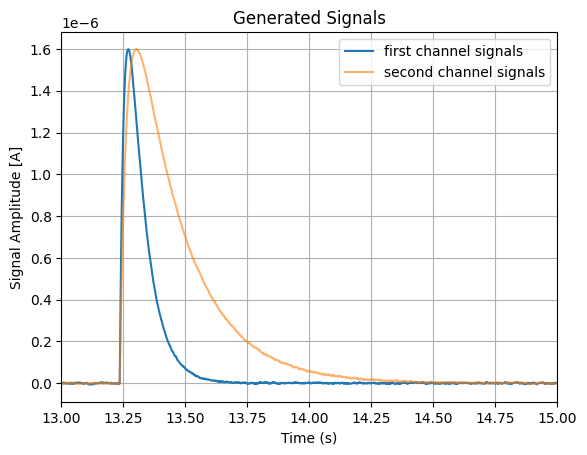

In [7]:
plt.plot(t*1e3, signal_1, label='first channel signals')
plt.plot(t*1e3, signal_2, alpha=0.6,label='second channel signals')
plt.ylabel("Signal Amplitude [A]")
plt.xlabel("Time (s)")
plt.grid()
plt.xlim([13,15])
plt.legend()
plt.title('Generated Signals')
plt.show()

## 2x2 Optimal Filter 
-----

This case is essentially the same as two OF1x1's, with the enhancement that if there was any correlated noise, our fitting would weight by it. 

In [8]:
# signals (nchans, nbins)
# should be an array (2,32768)
signal = np.array([signal_1, signal_2])
print(f'Signal matrix shape = {signal.shape}')
# templates (nchans, ntmps, nbins)
# should be a (2,2,32768) array

off_diagn_terms = np.zeros_like(template_1)
templates = np.asarray([[template_1, off_diagn_terms],[off_diagn_terms,template_2]])
print(f'Template matrix shape = {templates.shape}')

# channels 
#  format:
#   - string 'chan1|chan2' OR list ['chan1', 'chan2']
channels = ['signal_1', 'signal_2']
pretrigger_samples = nbins//2


Signal matrix shape = (2, 32768)
Template matrix shape = (2, 2, 32768)


In [9]:
# FIT
ofnxm = OFnxm(channels=channels, templates=templates, 
              csd=csd,sample_rate=fs, 
              pretrigger_samples=pretrigger_samples)


# calc
ofnxm.calc(signal=signal)

INFO: Adding noise CSD to OF base object
INFO: Calculating optimal filter!


#### Get Fit results and Fit overlay

$$
\text{fit\_overlay}[i, :] = \sum_{j=0}^{N_{\text{templates}}-1} \text{amp}[j] \cdot \text{rolled\_templates}[i, j, :]
$$

In [10]:
# Fit result 

# a good fit will be equal to the number of dof's (nbins*nchans-ntemps)
amp, t0, chi2 = ofnxm.get_fit_withdelay()
print(f"With Delay Fit: amp = {amp*1e6} uA, t_0 = {t0*1e6} us, chi^2 = {chi2}")

# fit overlay

#shift = int(t0 * fs)
#rolled_templates = np.roll(templates, shift, axis=-1)
# fit_overlay = np.sum(rolled_templates * amp[None, :, None], axis=1)
fit_overlay = ofnxm.get_fit_overlay(amp, t0)

With Delay Fit: amp = [1.59916026 1.59968601] uA, t_0 = 128.0 us, chi^2 = 66636.94759733044


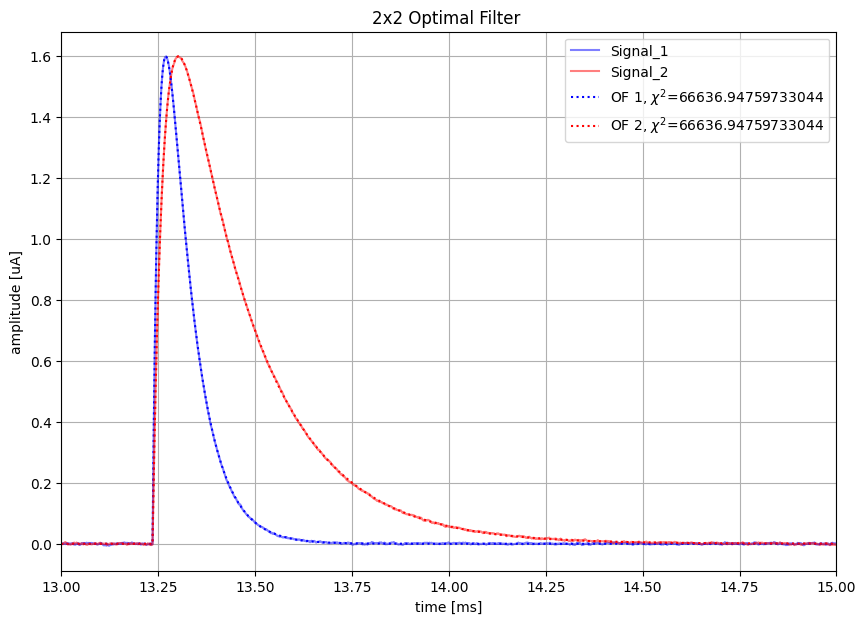

In [11]:
# time axis
xtime_ms = 1e3*np.arange(nbins)/fs

# define figure abd plot
fig, ax = plt.subplots(figsize=(10, 7))   
ax.plot(xtime_ms, signal_1*1e6, label='Signal_1', color='blue', alpha=0.5)
ax.plot(xtime_ms, signal_2*1e6, label='Signal_2', color='red', alpha=0.5)

ax.plot(xtime_ms, fit_overlay[0,:]*1e6,
        label=(r'OF 1, $\chi^2$='+f'{chi2}'),
        color='blue',
        linestyle='dotted')
ax.plot(xtime_ms, fit_overlay[1,:]*1e6,
        label=(r'OF 2, $\chi^2$='+f'{chi2}'),
        color='red',
        linestyle='dotted')
plt.grid('both')
plt.xlabel('time [ms]')
plt.ylabel('amplitude [uA]')
plt.xlim([13,15])
plt.title('2x2 Optimal Filter ')
plt.legend()

## 2x1 Optimal Filter

In [12]:
templates = np.array([[template_1],[off_diagn_terms]])
signal = np.array([signal_1, noise_2[0]]) #our signal on the second channel is just noise
print(f'Template matrix shape = {templates.shape}')
print(f'Signal matrix shape = {signal.shape}')
# channels 
#  format:
#   - string 'chan1|chan2' 
#   - OR list ['chan1', 'chan2']
channels = ['signal_1', 'signal_2']
#channels = 'signal_1 | signal_2'


pretrigger_samples = nbins//2

Template matrix shape = (2, 1, 32768)
Signal matrix shape = (2, 32768)


In [13]:
ofnxm = OFnxm(channels=channels, templates=templates,
              csd=csd,sample_rate=fs, 
              pretrigger_samples=pretrigger_samples)

INFO: Adding noise CSD to OF base object
INFO: Calculating optimal filter!


In [14]:
# calc
ofnxm.calc(signal=signal)

# get fit results
amp, t0, chi2 = ofnxm.get_fit_withdelay()
print(f"With Delay Fit: amp = {amp*1e6} uA, t_0 = {t0*1e6} us, chi^2 = {chi2}")


# fit overlay
fit_overlay = ofnxm.get_fit_overlay(amp, t0)


With Delay Fit: amp = [1.59916088] uA, t_0 = 128.0 us, chi^2 = 66637.21298891399


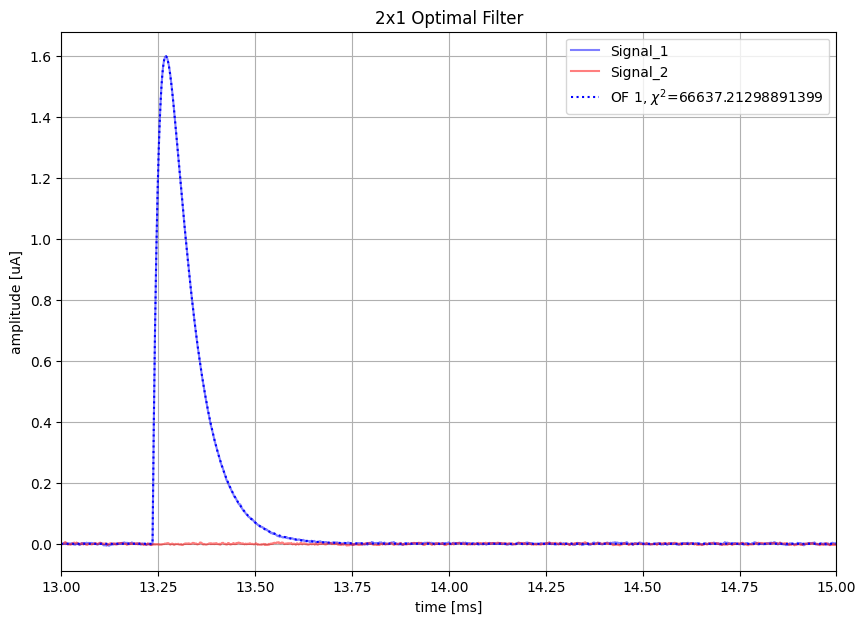

In [15]:
# time axis
xtime_ms = 1e3*np.arange(nbins)/fs

# define figure abd plot
fig, ax = plt.subplots(figsize=(10, 7))   
ax.plot(xtime_ms, signal[0]*1e6, label='Signal_1', color='blue', alpha=0.5)
ax.plot(xtime_ms, signal[1]*1e6, label='Signal_2', color='red', alpha=0.5)

ax.plot(xtime_ms, fit_overlay[0,:]*1e6,
        label=(r'OF 1, $\chi^2$='+f'{chi2}'),
        color='blue',
        linestyle='dotted')

plt.grid('both')
plt.xlabel('time [ms]')
plt.ylabel('amplitude [uA]')
plt.xlim([13,15])
plt.title('2x1 Optimal Filter')
plt.legend()

## 1x1 Optimal Filter

In [16]:
# templates can be either 1D (Nsamples,)  2D (1, Nsamples) or 3D (1,1, Nsamples)
# signal can be either 1D (Nsamples) or 2D (1, Nsamples)
templates = template_1
signal = signal_1 #our signal on the second channel is just noise
print(f'Template matrix shape = {templates.shape}')
print(f'Signal matrix shape = {signal.shape}')
# channels 
#  format:
#   - string 'chan1|chan2'  OR list ['chan1', 'chan2']
#   - single channel: string 'chan1'
channels = 'signal_1'
pretrigger_samples = nbins//2

Template matrix shape = (32768,)
Signal matrix shape = (32768,)


In [17]:
ofnxm = OFnxm(channels=channels, templates=templates,
              csd=psd_1,sample_rate=fs, 
              pretrigger_samples=pretrigger_samples)

INFO: Adding noise CSD to OF base object
INFO: Calculating optimal filter!


In [18]:
# calc
ofnxm.calc(signal=signal)

# get fit results
amp, t0, chi2 = ofnxm.get_fit_withdelay()
print(f"With Delay Fit: amp = {amp*1e6} uA, t_0 = {t0*1e6} us, chi^2 = {chi2}")

# fit overlay
#shift = int(t0 * fs)
#rolled_templates = np.roll(templates, shift, axis=-1)
fit_overlay = np.squeeze(ofnxm.get_fit_overlay(amp, t0))


With Delay Fit: amp = [1.59922112] uA, t_0 = 128.0 us, chi^2 = 33083.320382051636


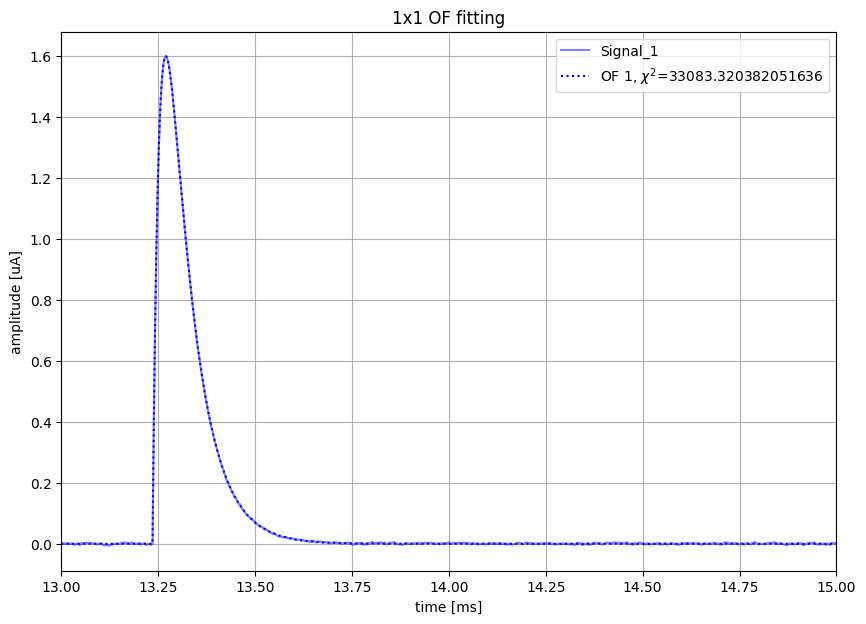

In [19]:
# time axis
xtime_ms = 1e3*np.arange(nbins)/fs

# define figure abd plot
fig, ax = plt.subplots(figsize=(10, 7))   
ax.plot(xtime_ms, signal*1e6, label='Signal_1', color='blue', alpha=0.5)

ax.plot(xtime_ms, fit_overlay*1e6,
        label=(r'OF 1, $\chi^2$='+f'{chi2}'),
        color='blue',
        linestyle='dotted')

plt.grid('both')
plt.xlabel('time [ms]')
plt.ylabel('amplitude [uA]')
plt.xlim([13,15])
plt.title('1x1 OF fitting')
plt.legend()

## 1x2 Optimal Filter

In [20]:
templates = np.array([[template_1,template_2]])
signal = signal_combined #our signal on the second channel is just noise
print(f'Template matrix shape = {templates.shape}')
print(f'Signal matrix shape = {signal.shape}')
# channels 
#  format:
#   - string 'chan1|chan2'  OR list ['chan1', 'chan2']
#   - single channel: string 'chan1'
channels = 'signal_combined'
pretrigger_samples = nbins//2

Template matrix shape = (1, 2, 32768)
Signal matrix shape = (32768,)


In [21]:
ofnxm = OFnxm(channels=channels, templates=templates,
              csd=psd_1,sample_rate=fs, 
              pretrigger_samples=pretrigger_samples)

INFO: Adding noise CSD to OF base object
INFO: Calculating optimal filter!


In [22]:
# calc
ofnxm.calc(signal=signal)

# get fit results
amp, t0, chi2 = ofnxm.get_fit_withdelay()
print(f"With Delay Fit: amp = {amp*1e6} uA, t_0 = {t0*1e6} us, chi^2 = {chi2}")


# fit overlay
fit_overlay = ofnxm.get_fit_overlay(amp,t0)

With Delay Fit: amp = [1.60082631 1.59856117] uA, t_0 = 128.0 us, chi^2 = 33081.38268383965


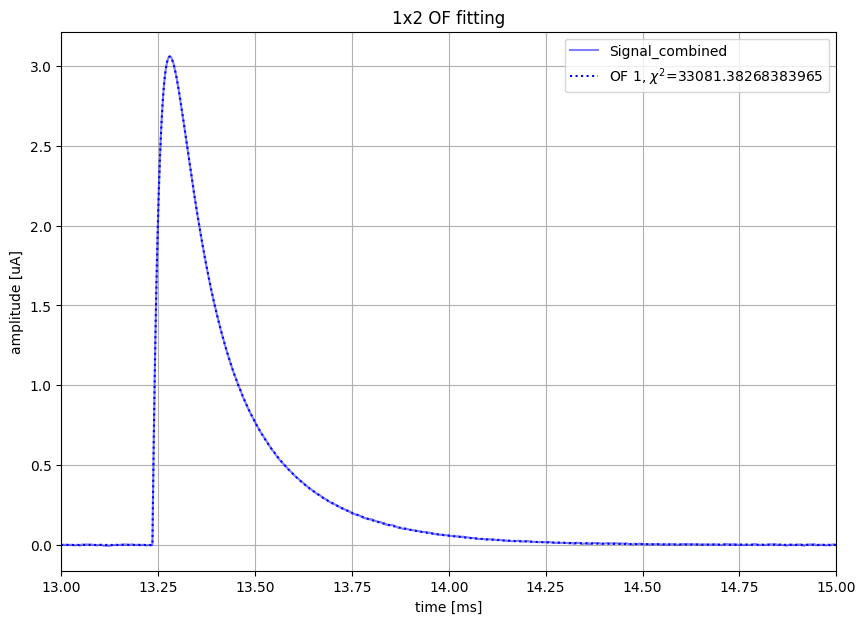

In [23]:
# time axis
xtime_ms = 1e3*np.arange(nbins)/fs

# define figure abd plot
fig, ax = plt.subplots(figsize=(10, 7))   
ax.plot(xtime_ms, signal*1e6, label='Signal_combined', color='blue', alpha=0.5)

ax.plot(xtime_ms, fit_overlay[0,:]*1e6,
        label=(r'OF 1, $\chi^2$='+f'{chi2}'),
        color='blue',
        linestyle='dotted')

plt.grid('both')
plt.xlabel('time [ms]')
plt.ylabel('amplitude [uA]')
plt.xlim([13,15])
plt.title('1x2 OF fitting')
plt.legend()